In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
train_df = pd.read_csv("data_train.csv",index_col=0)
test_df = pd.read_csv("data_test.csv", index_col=0)

In [3]:
test_df.head()

,id,vas_id,buy_time
0,3130519,2.0,1548018000
1,2000860,4.0,1548018000
2,1099444,2.0,1546808400
3,1343255,5.0,1547413200
4,1277040,2.0,1546808400


In [4]:
train_df.head()

,id,vas_id,buy_time,target
0,540968,8.0,1537131600,0.0
1,1454121,4.0,1531688400,0.0
2,2458816,1.0,1534107600,0.0
3,3535012,5.0,1535922000,0.0
4,1693214,1.0,1535922000,0.0


In [5]:
train_df.shape

(831653, 4)

In [6]:
# columns = np.arange(3,256)
# small_dtype = {}
# for item in columns:
#     small_dtype[item] = np.float32
# features_df = pd.read_csv("features.csv",sep="\t", index_col=0, dtype=small_dtype)
# features_df.head()

In [7]:
# features_df["id"] = features_df["id"].astype("int8")
# features_df["buy_time"] = features_df["buy_time"].astype("int8")
# features_df.memory_usage(deep=True)

In [8]:
# features_df.to_pickle("./features.pkl")

In [9]:
# features_df = pd.read_pickle("./features.pkl")
# features_df.memory_usage(deep=True)

In [10]:
# train_and_test = list(set(train_df.id.to_list() + test_df.id.to_list()))
# features_train_and_test = features_df.loc[features_df.id.isin(train_and_test),:]
# features_train_and_test.to_pickle("./features_train_and_test.pkl")

In [11]:
features_train_and_test = pd.read_pickle("./features_train_and_test.pkl")

In [12]:
train_complete = train_df.merge(features_train_and_test, on=["id", "buy_time"])

In [13]:
# corr_matrix = train_df.corr()
# corr_matrix = np.round(corr_matrix,2)
# corr_matrix[np.abs(corr_matrix) < 0.3] = 0

In [14]:
# plt.figure(figsize=(15,10))
# sns.set(font_scale=1.4)
# sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

# plt.title('Correlation matrix');

In [15]:
X = train_complete.drop("target", axis=1)
y = train_complete["target"]

In [16]:
# print("ID уникален? {}".format(X.index.is_unique))
# print("Сколько дубликатов? {}".format(X.duplicated().sum()))
# print("Каков процент пропусков? {} ".format((X.isnull().sum() > 0).sum()/X.shape[1]*100))

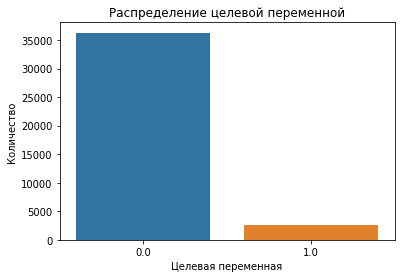

In [17]:
import seaborn as sns
ax = sns.countplot(y)
ax.set_xlabel("Целевая переменная")
ax.set_ylabel("Количество")
ax.set_title("Распределение целевой переменной");

In [18]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

train_idx, test_idx = train_test_split(X.index, test_size=0.35, random_state=RANDOM_STATE)

y_train, y_test = y.loc[train_idx], y.loc[test_idx]
X_train, X_test = X.loc[train_idx], X.loc[test_idx]

print("Train")
print(y.loc[train_idx].value_counts()/train_idx.shape[0])
print()
print("Test")
print(y.loc[test_idx].value_counts()/test_idx.shape[0])

Train
0.0    0.932205
1.0    0.067795
Name: target, dtype: float64

Test
0.0    0.931948
1.0    0.068052
Name: target, dtype: float64


In [19]:
scaler = StandardScaler()

In [20]:
all_feat = X.columns.tolist()

In [21]:
X_nunique = X.apply(lambda x: x.nunique(dropna=False))

Признаки - константы

In [22]:
const_feat = X_nunique[X_nunique == 1].index.tolist()

In [23]:
selected_feat = list(set(all_feat) - set(const_feat))

Бинарные признаки

In [24]:
bin_feat = set(X.loc[:,selected_feat].columns[((X.loc[:,selected_feat].min()==0) &\
                                (X.loc[:,selected_feat].max()==1) &\
                                (X.loc[:,selected_feat].isnull().sum()==0))])

In [25]:
selected_feat = list(set(selected_feat) - bin_feat)

In [26]:
X_train_scale = scaler.fit_transform(X_train.loc[:,selected_feat])
X_test_scale = scaler.transform(X_test.loc[:,selected_feat])

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate

In [28]:
balanced_log_reg = LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1, class_weight="balanced")

In [29]:
log_reg_step = ("logistic_regression", balanced_log_reg)

In [30]:
base_estimator = Pipeline([log_reg_step])

In [31]:
def run_cv(estimator, X, y, scoring='roc_auc', model_name=""):
    cv_res = cross_validate(estimator, X, y, scoring=scoring, n_jobs=-1)
    print("{} {}={:.2f}(+/-{:.4f})".format(model_name, scoring, cv_res['test_score'].mean(), cv_res['test_score'].std() *2))

In [32]:
run_cv(base_estimator, X_train_scale, y_train, model_name="Baseline")

Baseline roc_auc=0.80(+/-0.0097)


In [33]:
base_estimator.fit(X_train_scale, y_train)

Pipeline(steps=[('logistic_regression',
                 LogisticRegression(class_weight='balanced', n_jobs=-1,
                                    random_state=42))])

In [34]:
base_preds = base_estimator.predict_proba(X_test_scale)[:,1]

In [35]:
from sklearn.metrics import roc_curve, auc

In [36]:
fpr, tpr, _ = roc_curve(y_test, base_preds)

Baseline: AUC_ROC = 0.809


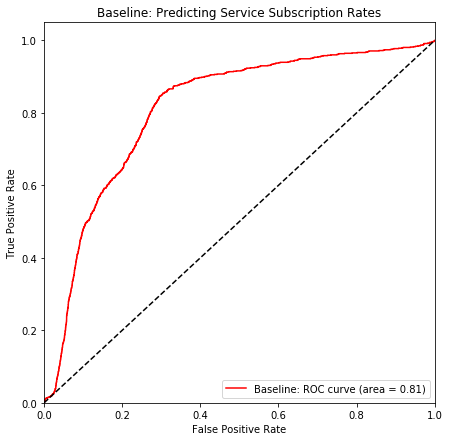

In [37]:
def plot_roc_curve(fpr, tpr, model_name="", color=None):
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Predicting Service Subscription Rates' % model_name)
    plt.legend(loc="lower right")

plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "Baseline", color='r')
print("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))

In [38]:
from sklearn.metrics import classification_report

In [39]:
def train_model(model, X_train, y_train, X_valid, y_valid, feature_names):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    
    print("F1 Score: {}".format(np.round(f1_score(y_valid, y_pred, average='macro'),3)))
    print("-------------------------------------------")
    print(classification_report(y_valid, y_pred > 0.5))
    print("-------------------------------------------")
    print(pd.DataFrame(model.coef_, columns=feature_names, \
                       index=["weight"]).T.sort_values(by="weight", ascending=False).head(20))

### Linear Regression with Balanced Class Weight

In [40]:
train_model(balanced_log_reg, X_train_scale, y_train, X_test_scale, y_test, X_train.loc[:,selected_feat].columns)

F1 Score: 0.564
-------------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.74      0.84     12695
         1.0       0.18      0.78      0.29       927

    accuracy                           0.74     13622
   macro avg       0.58      0.76      0.56     13622
weighted avg       0.92      0.74      0.80     13622

-------------------------------------------
          weight
vas_id  1.252000
88      0.625856
167     0.607173
10      0.449105
137     0.421775
138     0.370410
84      0.340142
31      0.317700
122     0.267366
101     0.255442
230     0.227898
12      0.227250
6       0.201579
45      0.199907
169     0.196448
199     0.195004
176     0.184293
83      0.176565
173     0.168146
18      0.140003


In [41]:
from sklearn.ensemble import RandomForestRegressor

In [42]:
rand_for_class = RandomForestRegressor(random_state=RANDOM_STATE, max_depth=6, n_estimators=500)

In [43]:
rand_for_step = ('rand_for', rand_for_class)

In [44]:
ran_estimator = Pipeline([rand_for_step])

In [45]:
ran_estimator.fit(X_train_scale, y_train)

Pipeline(steps=[('rand_for',
                 RandomForestRegressor(max_depth=6, n_estimators=500,
                                       random_state=42))])

In [46]:
ran_for_preds = ran_estimator.predict(X_test_scale)

In [47]:
fpr, tpr, _ = roc_curve(y_test, ran_for_preds)

Random Forest Model: AUC_ROC = 0.931


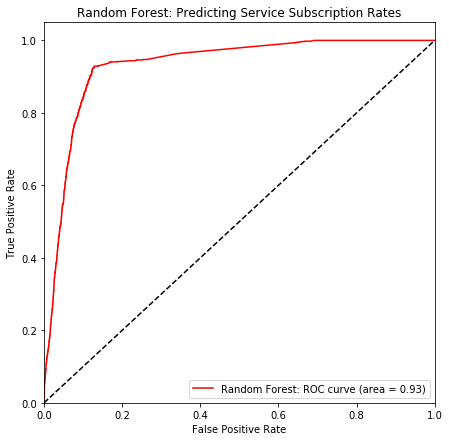

In [48]:
plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "Random Forest", color='r')
print("Random Forest Model: AUC_ROC = %.3f" % auc(fpr, tpr))

In [49]:
from sklearn.metrics import precision_recall_curve

In [50]:
def train_forest(model, X_train, y_train, X_valid, y_valid, feature_names):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    
    precision, recall, thresholds = precision_recall_curve(y_valid, y_pred)
    
    fscore = (2 * precision * recall)/(precision + recall)
    
    ix = np.argmax(fscore)
    
    print("F1 Score: {}".format(np.round(fscore[ix],3)))
    print("-------------------------------------------")
    print(classification_report(y_valid, y_pred > 0.5))
    print("-------------------------------------------")
    print(pd.DataFrame(model.feature_importances_, columns=["weight"], \
                       index=[feature_names]).sort_values(by="weight", ascending=False).head(10))

In [51]:
train_forest(rand_for_class, X_train_scale, y_train, X_test_scale,\
            y_test, X_train.loc[:,selected_feat].columns)

F1 Score: 0.544
-------------------------------------------
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     12695
         1.0       0.67      0.06      0.11       927

    accuracy                           0.93     13622
   macro avg       0.80      0.53      0.54     13622
weighted avg       0.92      0.93      0.91     13622

-------------------------------------------
            weight
vas_id    0.698205
buy_time  0.134275
id        0.005939
207       0.004817
250       0.003189
245       0.002940
115       0.002850
226       0.002689
1         0.002419
40        0.002414


In [52]:
from catboost import CatBoostClassifier

In [77]:
cat_class = CatBoostClassifier(n_estimators=1200, max_depth=8, eval_metric='F1',\
                                           random_state=RANDOM_STATE)

In [78]:
cat_step = ("catboost", cat_class)

In [79]:
cat_estimator = Pipeline([cat_step])

In [80]:
def train_model(model, X_train, y_train, X_valid, y_valid, feature_names):
    
    model.fit(X_train, y_train, verbose=False)
    y_pred = model.predict(X_valid)
    
    print("F1 Score: {}".format(np.round(f1_score(y_valid, y_pred, average='macro'),3)))
    print("-------------------------------------------")
    print(classification_report(y_valid, y_pred > 0.5))
    print("-------------------------------------------")
    print(pd.DataFrame(model.feature_importances_, columns=["weight"], \
                       index=[feature_names]).sort_values(by="weight", ascending=False).head(20))

In [81]:
train_model(cat_class, X_train_scale, y_train, X_test_scale,\
            y_test, X_train.loc[:,selected_feat].columns)

F1 Score: 0.627
-------------------------------------------
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97     12695
         1.0       0.55      0.20      0.29       927

    accuracy                           0.93     13622
   macro avg       0.74      0.59      0.63     13622
weighted avg       0.92      0.93      0.92     13622

-------------------------------------------
             weight
vas_id    27.582325
buy_time  12.427346
id         2.141403
226        1.868402
128        1.305507
164        1.287294
240        1.185329
58         1.182931
144        1.068228
115        1.052117
236        0.994786
52         0.974742
145        0.964040
5          0.962587
207        0.951985
1          0.944524
188        0.853049
114        0.830326
3          0.798276
222        0.763069
